# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [20]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [21]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
from sklearn.decomposition import PCA

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
import sys
sys.path.append('/wynton/group/ye/mincheol/Github/scrna-parameter-estimation/simplesc')
import scme, utils

In [10]:
data_path = '/wynton/group/ye/mincheol/parameter_estimation/interferon_data/'

### Read the AnnData object

In [11]:
adata = sc.read(data_path + 'interferon.raw.h5ad')
adata = adata[:, adata.var.index.map(lambda x: x[:2] != 'HB')]
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


In [32]:
adata.obs.cell.value_counts()

CD4 T cells          10373
CD14+ Monocytes      5355 
B cells              2570 
CD8 T cells          2039 
NK cells             1991 
FCGR3A+ Monocytes    1592 
Dendritic cells      432  
Megakaryocytes       208  
Name: cell, dtype: int64

In [33]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


### TF - gene differential correlation

In [24]:
ct = 'CD4 T cells'

In [25]:
with open(data_path + 'stim_effect_1d_moments.pkl', 'rb') as f:
    moment_dict_1d = pkl.load(f)

In [26]:
with open(data_path + 'stim_effect_2d.pkl', 'rb') as f:
    dc_result = pkl.load(f)
with open(data_path + 'stim_effect_ci_2d.pkl', 'rb') as f:
    corr_ci = pkl.load(f)

In [27]:
idxs_1 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_1']
idxs_2 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']

In [60]:
gene_pair_idx = np.array(list(itertools.product(range(len(idxs_1)), range(len(idxs_2)))))
genes = pd.DataFrame(
    data=list(zip(
        adata.var.index[idxs_1[gene_pair_idx[:, 0]]], 
        adata.var.index[idxs_2[gene_pair_idx[:, 1]]],
        dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_1'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]],
        dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_2'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]])),
    columns=['gene_1', 'gene_2', 'corr_1', 'corr_2'])

In [62]:
genes.sort_values('corr_2', ascending=False)

,gene_1,gene_2,corr_1,corr_2
1800,IRF8,HLA-DQA1,0.006690,0.677542
2065,IRF8,HLA-DQB1,0.001598,0.668030
2185,IRF8,CXCL11,-0.001951,0.604212
1198,STAT6,BLNK,-0.060629,0.570476
2069,IRF8,MNDA,-0.003385,0.556392
1536,IRF1,NFKBIA,0.202350,0.474599
1379,IRF1,KLF6,0.103945,0.474052
1351,IRF1,LAT2,0.065471,0.440748
1943,IRF8,HLA-DRB1,0.025969,0.426119
2090,IRF8,DUSP10,-0.007053,0.408565


In [53]:
def line_from_correlation(corr, corr_ci, x, y, mu_x, mu_y, sigma_x, sigma_y, color_order):
    
#     mu_x = x.mean()
#     mu_y = y.mean()
#     sigma_x = x.std()
#     sigma_y = y.std()
    
    beta_up = sigma_y/sigma_x*(corr + corr_ci)
    alpha_up = mu_y - beta_up*mu_x
    
    beta = sigma_y/sigma_x*(corr)
    alpha = mu_y - beta*mu_x
    
    beta_down = sigma_y/sigma_x*(corr - corr_ci)
    alpha_down = mu_y - beta_down*mu_x
    
    x_range = np.arange(x.min(), 10, 0.1)
    
    up = beta_up*x_range + alpha_up
    line = beta*x_range + alpha
    down = beta_down*x_range + alpha_down
            
    plt.fill_between(x_range, up, down, alpha=0.3, color=sns.color_palette()[color_order])
    plt.plot(x_range, line, color=sns.color_palette()[color_order])

In [54]:
def plot_diff_corr(dc_result, corr_ci, moment_dict_1d, ct, gene_1, gene_2, offset=0.1):

    idxs_1 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_1']
    idxs_2 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']
    
    gene_idx_1 = np.where(adata.var.index == gene_1)[0][0]
    gene_idx_2 = np.where(adata.var.index == gene_2)[0][0]
    
    df_1 = pd.DataFrame(
        adata[adata.obs.cell_type == ct + ' - ctrl'].X[:, [gene_idx_1, gene_idx_2]].toarray(),
        columns=['gene_1', 'gene_2'])
    df_2 = pd.DataFrame(
            adata[adata.obs.cell_type == ct + ' - stim'].X[:, [gene_idx_1, gene_idx_2]].toarray(),
            columns=['gene_1', 'gene_2'])

    count_df_1 = df_1\
        .merge(
            pd.DataFrame(df_1.groupby(['gene_1', 'gene_2']).size().reset_index()),
            on=['gene_1', 'gene_2'], 
            how='left')

    count_df_2 = df_2\
        .merge(
            pd.DataFrame(df_2.groupby(['gene_1', 'gene_2']).size().reset_index()),
            on=['gene_1', 'gene_2'], 
            how='left')
    
    count_df_1['size'] = count_df_1[0]
    count_df_1['log_size'] = np.sqrt((count_df_1['size']))+10

    count_df_2['size'] = count_df_2[0]
    count_df_2['log_size'] = np.sqrt((count_df_2['size']))+10
    
    y1 = adata[adata.obs.cell_type == ct + ' - ctrl'].X[:, gene_idx_2].toarray().reshape(-1) - offset
    x1 = adata[adata.obs.cell_type == ct + ' - ctrl'].X[:, gene_idx_1].toarray().reshape(-1) - offset

    y2 = adata[adata.obs.cell_type == ct + ' - stim'].X[:, gene_idx_2].toarray().reshape(-1) + offset
    x2 = adata[adata.obs.cell_type == ct + ' - stim'].X[:, gene_idx_1].toarray().reshape(-1) + offset
    
    mu_x1 = moment_dict_1d[ct + ' - ctrl']['first'][gene_idx_1]
    mu_y1 = moment_dict_1d[ct + ' - ctrl']['first'][gene_idx_2]
    mu_x2 = moment_dict_1d[ct + ' - stim']['first'][gene_idx_1]
    mu_y2 = moment_dict_1d[ct + ' - stim']['first'][gene_idx_2]

    sigma_x1 = np.sqrt(moment_dict_1d[ct + ' - ctrl']['second'][gene_idx_1])
    sigma_y1 = np.sqrt(moment_dict_1d[ct + ' - ctrl']['second'][gene_idx_2])
    sigma_x2 = np.sqrt(moment_dict_1d[ct + ' - stim']['second'][gene_idx_1])
    sigma_y2 = np.sqrt(moment_dict_1d[ct + ' - stim']['second'][gene_idx_2])

    corr_1 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_1'][
        np.argwhere(idxs_1 == gene_idx_1)[0][0], 
        np.argwhere(idxs_2 == gene_idx_2)[0][0]]

    corr_ci_1 = corr_ci[ct + ' - ctrl']['corr'][
        np.argwhere(idxs_1 == gene_idx_1)[0][0], 
        np.argwhere(idxs_2 == gene_idx_2)[0][0]]

    corr_2 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_2'][
        np.argwhere(idxs_1 == gene_idx_1)[0][0], 
        np.argwhere(idxs_2 == gene_idx_2)[0][0]]

    corr_ci_2 = corr_ci[ct + ' - stim']['corr'][
        np.argwhere(idxs_1 == gene_idx_1)[0][0], 
        np.argwhere(idxs_2 == gene_idx_2)[0][0]]

    plt.scatter(x1, y1, s=count_df_1.log_size, label='control')
    
    plt.scatter(x2, y2, s=count_df_2.log_size, label='IFN-B')
    
    line_from_correlation(
        corr_1, corr_ci_1, 
        x1 + offset, y1 + offset,
        mu_x1, mu_y1, sigma_x1, sigma_y1,
        color_order=0)
    
    line_from_correlation(
        corr_2, corr_ci_2, 
        x2 - offset, y2 - offset, 
        mu_x2, mu_y2, sigma_x2, sigma_y2,
        color_order=1)
    
    plt.xlabel('{} expression'.format(gene_1))
    plt.ylabel('{} expression'.format(gene_2))
    plt.legend()
    plt.title('Relationship between {} \n and {} in {}'.format(gene_1, gene_2, ct))

In [55]:
ct = 'CD4 T cells'

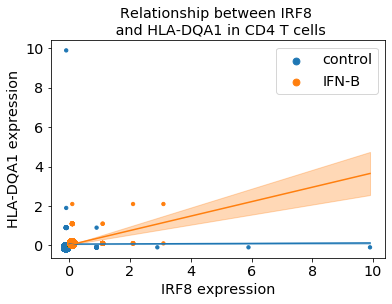

In [56]:
plot_diff_corr(dc_result, corr_ci, moment_dict_1d, ct, 'IRF8', 'HLA-DQA1', offset=0.1)

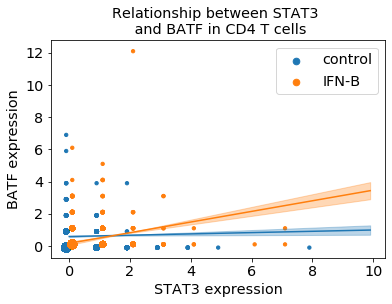

In [61]:
plot_diff_corr(dc_result, corr_ci, moment_dict_1d, 'CD4 T cells', 'STAT3', 'BATF', offset=0.1)

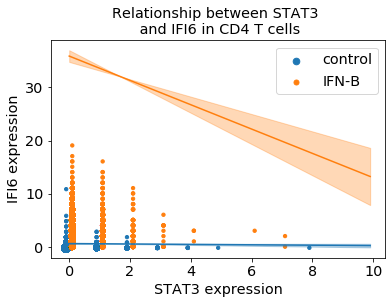

In [62]:
plot_diff_corr(dc_result, corr_ci, moment_dict_1d, 'CD4 T cells', 'STAT3', 'IFI6', offset=0.1)